# Import libraries


In [1]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from underthesea import word_tokenize
from underthesea import text_normalize
from datetime import datetime
import timeit
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import os
import urllib.request

import torch
from transformers import (
    RobertaForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from nltk.sentiment.vader import SentimentIntensityAnalyzer

d:\Work\PQ\support\nlp\Sentiment-analysis\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download files


In [2]:
def download_and_save(url, file_path, file_name):
    if not os.path.exists(file_path):
        os.makedirs(file_path, exist_ok=True)
    if os.path.exists(file_path + file_name):
        print(f"{file_name} already exists in {file_path}")
        return
    try:
        urllib.request.urlretrieve(url, file_path + file_name)
        print(f"Downloaded {file_name} from {url}")
    except Exception as e:
        print(f"Error downloading {file_name} from {url}: {e}")

## Define file path


In [3]:
data_path = "./data/"
image_path = "./images/"

In [4]:
# path where the file will be saved
file_path = data_path
# name of the file
file_name = "stopwords.txt"
# URL of the file to download
url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
# download the file
download_and_save(url, file_path, file_name)

stopwords.txt already exists in ./data/


In [5]:
# path where the file will be saved
file_path = image_path + "mask/"
# name of the file
file_name = "oval.png"
# URL of the file to download
url = "https://media.istockphoto.com/id/951462426/vi/vec-to/b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c.jpg?s=612x612&w=0&k=20&c=uvagMnaVackcfH5TN7wvuO8-Ldn-XkvkqWgc5MSANg8="
# download the file
download_and_save(url, file_path, file_name)

oval.png already exists in ./images/mask/


# Prepare data


In [6]:
source = input("Chọn nguồn trang để phân tích dữ liệu: \n1.CafeF \n2.VietStock \n")
if source.lower() == "cafef" or source == "1":
    source = "cafef"
elif source.lower() == "vietstock" or source == "2":
    source = "vietstock"

### Define company list & stock exchange


In [7]:
company_list = ["API", "AGG", "BID", "FPT", "VCB", "ACV", "OIL", "ABB", "ABC"]
company_focused = ["FPT", "OIL", "VCB", "API"]

company_list.sort()
company_focused.sort()

company_news = dict()

## Import data from CSV


In [8]:
def get_company_news(imported_news):
    for record in imported_news:
        company_name = record["Company"]
        # title = record['News']
        title = record["Title"]
        content = record["Content"]
        link = record["Link"]
        price = record["Price"]
        timeline = record["Timeline"]
        if company_name not in company_news:
            company_news[company_name] = dict()
            company_news[company_name]["title"] = [title]
            company_news[company_name]["content"] = [content]
            company_news[company_name]["link"] = [link]
            company_news[company_name]["price"] = [price]
            company_news[company_name]["timeline"] = [timeline]
        else:
            company_news[company_name]["title"].append(title)
            company_news[company_name]["content"].append(content)
            company_news[company_name]["link"].append(link)
            company_news[company_name]["price"].append(price)
            company_news[company_name]["timeline"].append(timeline)

In [9]:
if source.lower() == "cafef":
    cafef_news = pd.read_csv("./data/cafef.csv")
    imported_news = cafef_news.to_dict("records")
else:
    vietstock_news = pd.read_csv("./data/vietstock.csv")
    imported_news = vietstock_news.to_dict("records")
get_company_news(imported_news)

## List company data


In [10]:
for company in company_list:
    print(f"{company}: {company_news[company]['title']}")

    print(f"Number of title: {len(company_news[company]['title'])}")

    print(f"Number of content: {len(company_news[company]['content'])}")

    print(f"Number of link: {len(company_news[company]['link'])}")

    print(f"Number of price: {len(company_news[company]['price'])}")

    print(f"Number of timeline: {len(company_news[company]['timeline'])}")

ABB: ['Ngân hàng tìm hướng hút CASA', 'Cổ phiếu ngân hàng phân hóa', 'International Finance Corporation không còn là cổ đông lớn', 'CBTT vv phê duyệt Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ Ngân hàng TMCP An Bình', 'Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ', '[Infographics] Toàn cảnh kết quả kinh doanh ngân hàng quý 1/2024', 'Thoái toàn bộ gần 85 triệu cp, IFC không còn là cổ đông của ABBank', 'Khối ngoại bán thỏa thuận gần 85 triệu cp ABB, cao hơn 22% thị giá', 'Gần 69 triệu cp ABB khớp lệnh kỷ lục phiên 21/05', 'Tín dụng quý 2 sẽ khởi sắc?', 'Đâu là đỉnh của nợ xấu?', 'Lợi nhuận ngân hàng quý 1 giảm phụ thuộc vào tín dụng', 'Chênh lệch bình quân giữa lãi suất cho vay và huy động từ 2-4%/năm', 'Cổ phiếu ngân hàng “hụt hơi”', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024', 'Kế hoạch lợi nhuận tăng tr

In [11]:
stock_price = list()
date_time = list()

In [12]:
for company, item in company_news.items():
    stock_price.append(item["price"])
    date_time.append(item["timeline"])

## Preprocess data


### Tokenize Vietnamese


In [13]:
stop_words = set()
with open("./data/stopwords.txt", "r", encoding="utf-8") as f:
    for line in f:
        stop_words.add(line.strip())

In [14]:
def clean_text(text):
    # lowercase text
    text = text.lower()

    # reduce repeated character (e.g. 'aaabbb' -> 'ab')
    text = re.sub(r"([a-z]+?)\1+", r"\1", text)

    # ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    # reduce consecutive punctuation
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    # remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()

    while text.endswith(tuple(string.punctuation + string.whitespace)):
        text = text[:-1]

    while text.startswith(tuple(string.punctuation + string.whitespace)):
        text = text[1:]

    # remove all punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # reduce multiple spaces
    text = re.sub(r"\s+", " ", text)

    # make sure punctunation is in the right letter (Vietnamese case)
    text = text_normalize(text)

    # tokenize the cleaned text
    text = word_tokenize(text, format="text")
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)
    text = text.split(" ")

    # remove stop words
    text = [word for word in text if word not in stop_words]
    text = " ".join(text)
    
    return text

In [15]:
for company, item in company_news.items():
    company_news[company]["tokenized_news"] = list()
    for title in item["title"]:
        title = clean_text(title)
        company_news[company]["tokenized_news"].append(title)

In [16]:
for company, item in company_news.items():
    company_news[company]["tokenized_content"] = list()
    for title in item["content"]:
        title = clean_text(title)
        company_news[company]["tokenized_content"].append(title)

### Plot word cloud


In [17]:
chart_path = image_path + "chart/"
if not os.path.exists(chart_path):
    os.makedirs(chart_path, exist_ok=True)

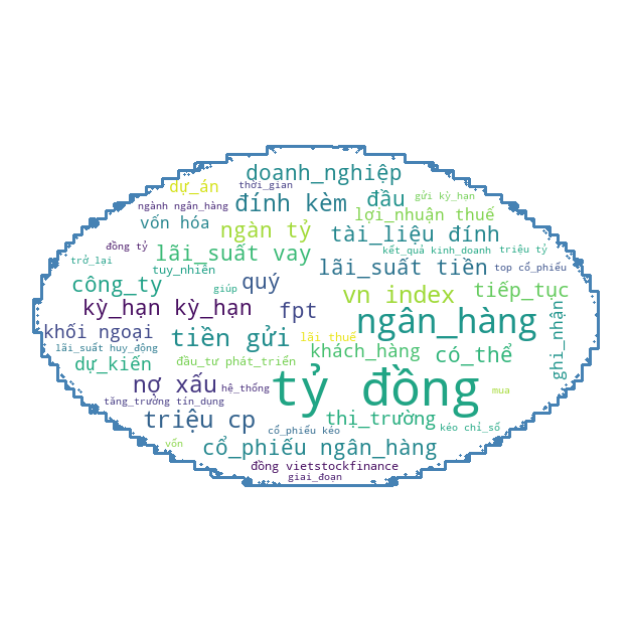

In [18]:
mask = np.array(Image.open(image_path + "mask/oval.png"))

# example data (replace with your actual data)
titles = list()
for company, item in company_news.items():
    titles.extend(item["tokenized_content"])
titles = " ".join(titles)

# create WordCloud object with custom mask and parameters
wordcloud = WordCloud(
    background_color="white",
    mask=mask,
    #   stopwords=STOPWORDS,
    contour_width=2,
    contour_color="steelblue",
    #   max_words=100,
    max_font_size=50,
    min_font_size=10,
)

# generate word cloud
wordcloud.generate(titles)

# plot the WordCloud image
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(chart_path + "wordcloud.png")
plt.show()

### Plot title length


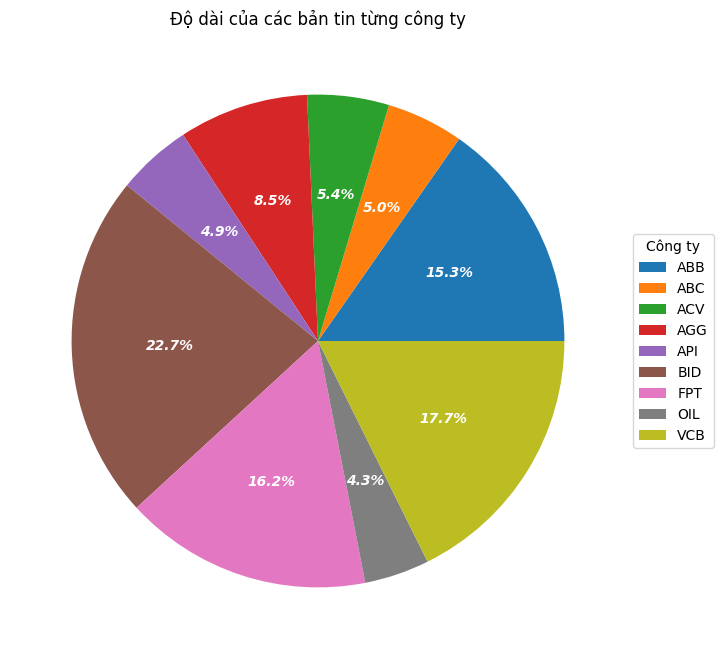

In [19]:
company_names = list(company_news.keys())
news_lengths = [len(item["title"]) for item in company_news.values()]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(
    news_lengths,
    autopct=lambda pct: "{:.1f}%".format(pct),
    textprops=dict(color="w", style="italic"),
)

ax.legend(
    wedges,
    company_names,
    title="Công ty",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
)

plt.setp(autotexts, size=10, weight="bold")
ax.set_title("Độ dài của các bản tin từng công ty")

plt.savefig(chart_path + "news_distribution.png")
plt.show()

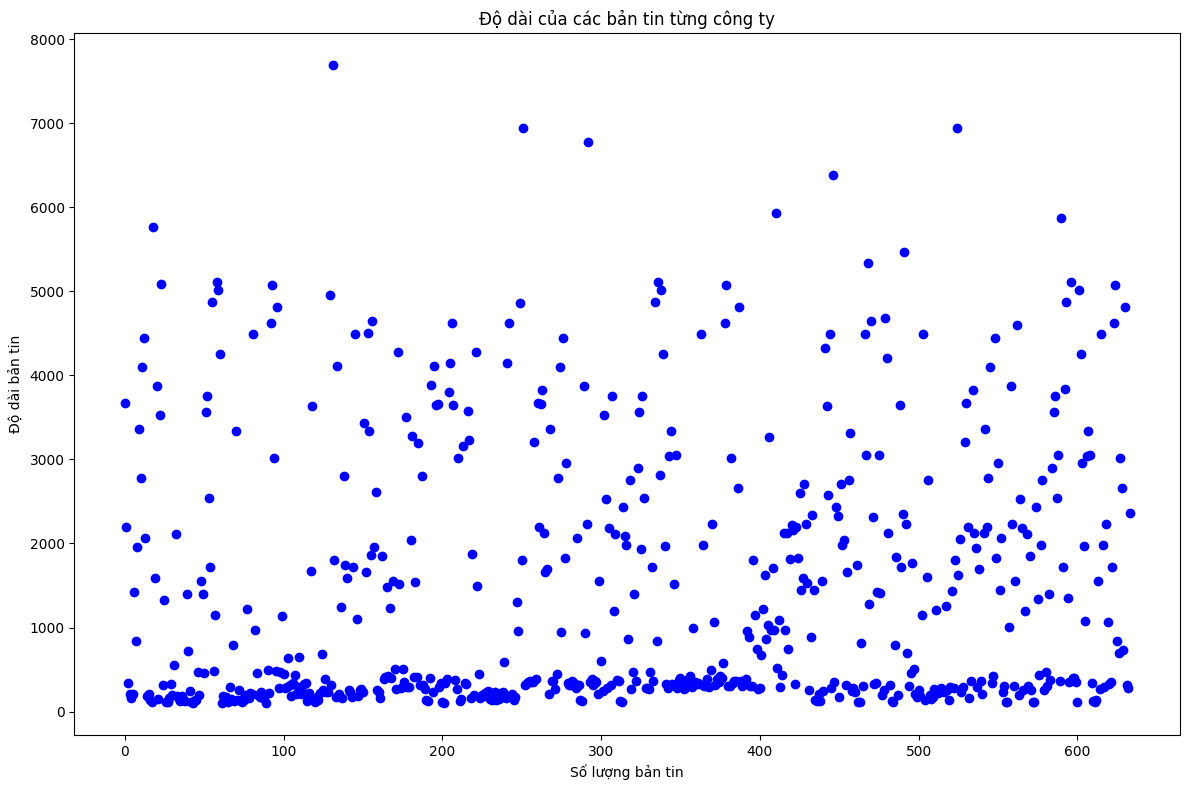

In [20]:
tokenized_news_lengths = list()
company_indices = list()

for company in company_news:
    for item in company_news[company]["tokenized_content"]:
        tokenized_news_lengths.append(len(item))
        company_indices.append(company)

# Tạo mảng chỉ số của từng tin tức
indices = list(range(len(tokenized_news_lengths)))

# Vẽ biểu đồ scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(indices, tokenized_news_lengths, marker="o", color="b")

# Đặt nhãn cho các trục
plt.xlabel("Số lượng bản tin")
plt.ylabel("Độ dài bản tin")
plt.title("Độ dài của các bản tin từng công ty")

# Định dạng số trên trục y để hiển thị số nguyên
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

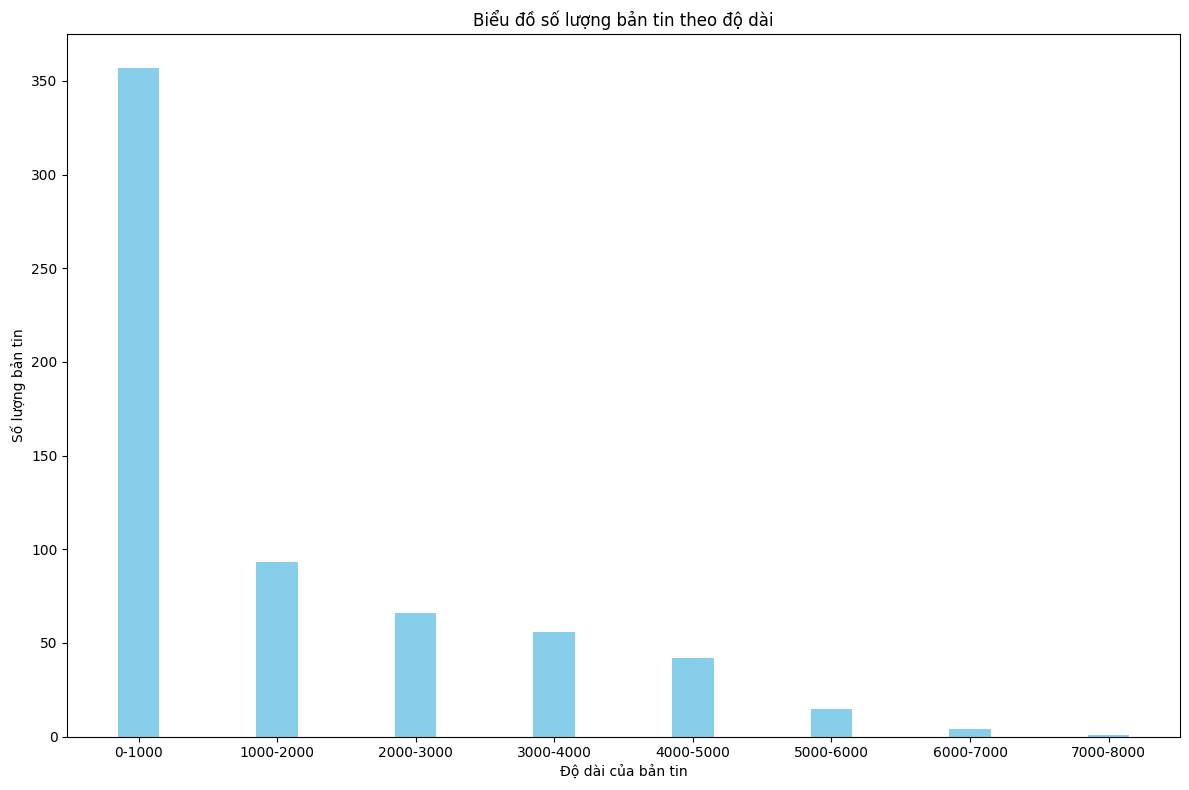

In [21]:
group_lengths = dict()

for company, item in company_news.items():
    for tokenized_content in item["tokenized_content"]:
        news_length = len(tokenized_content)
        if news_length in group_lengths:
            group_lengths[news_length] += 1
        else:
            group_lengths[news_length] = 1
grouped_lengths = dict()

# range for each step
bin_size = 1000

for length, count in group_lengths.items():
    bin_start = (length // bin_size) * bin_size
    bin_end = bin_start + bin_size
    bin_label = f"{bin_start}-{bin_end}"

    if bin_label in grouped_lengths:
        grouped_lengths[bin_label] += count
    else:
        grouped_lengths[bin_label] = count

lengths = list(grouped_lengths.keys())
counts = list(grouped_lengths.values())

sorted_lengths = sorted(
    lengths,
    key=lambda x: (
        int(re.match(r"(\d+)-", x).group(1)) if re.match(r"(\d+)-", x) else float("inf")
    ),
)
# combine counts and lengths into pairs
pairs = list(zip(counts, lengths))

# sort pairs based on lengths (using the index 1 of each pair)
sorted_pairs = sorted(
    pairs,
    key=lambda x: (
        int(re.match(r"(\d+)-", x[1]).group(1))
        if re.match(r"(\d+)-", x[1])
        else float("inf")
    ),
)
# separate sorted counts and lengths from sorted pairs
sorted_counts = [pair[0] for pair in sorted_pairs]
sorted_lengths = [pair[1] for pair in sorted_pairs]

# plot the bar chart
plt.figure(figsize=(12, 8))
plt.bar(sorted_lengths, sorted_counts, color="skyblue", width=0.3)
plt.xlabel("Độ dài của bản tin")
plt.ylabel("Số lượng bản tin")
plt.title("Biểu đồ số lượng bản tin theo độ dài")

plt.tight_layout()
plt.savefig(chart_path + "news_length.png")
plt.show()

### Length of focused company


API: 31
FPT: 103
OIL: 27
VCB: 112


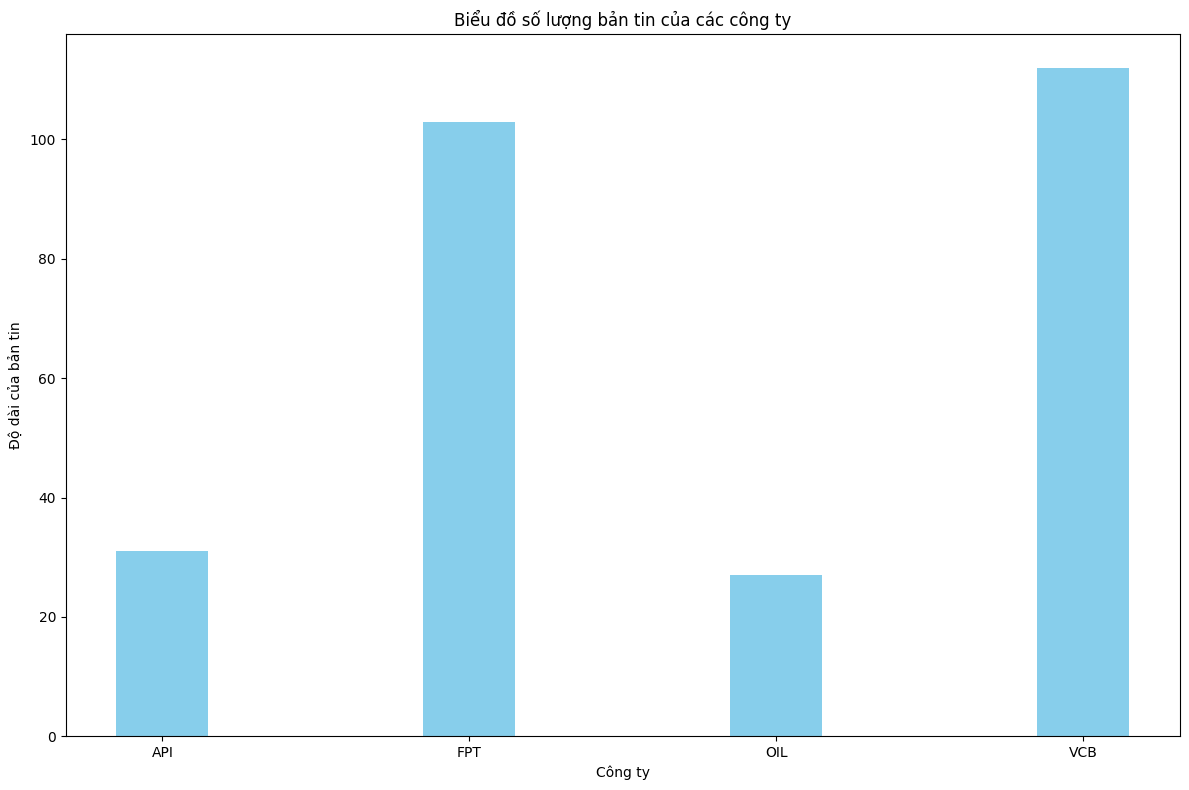

In [22]:
for company in company_focused:
    print(f"{company}: {len(company_news[company]['title'])}")

plt.figure(figsize=(12, 8))
plt.bar(
    company_focused,
    [len(company_news[company]["title"]) for company in company_focused],
    color="skyblue",
    width=0.3,
)
plt.xlabel("Công ty")
plt.ylabel("Độ dài của bản tin")
plt.title("Biểu đồ số lượng bản tin của các công ty")

plt.tight_layout()
plt.show()

# Use models & libraries


## Use model VADER from NLTK


### Load model


In [23]:
analyzer = SentimentIntensityAnalyzer()

In [24]:
start = timeit.default_timer()

for company, item in company_news.items():
    company_news[company]["sentiment"] = list()
    for title in item["tokenized_news"]:
        sentiment = analyzer.polarity_scores(title)
        company_news[company]["sentiment"].append(sentiment["compound"])
    #   print(f"{company}: {title} - {sentiment}")

stop = timeit.default_timer()

vader_time_execution = stop - start

### Plot sentiment score


In [25]:
vader_sentiment_scores = list()

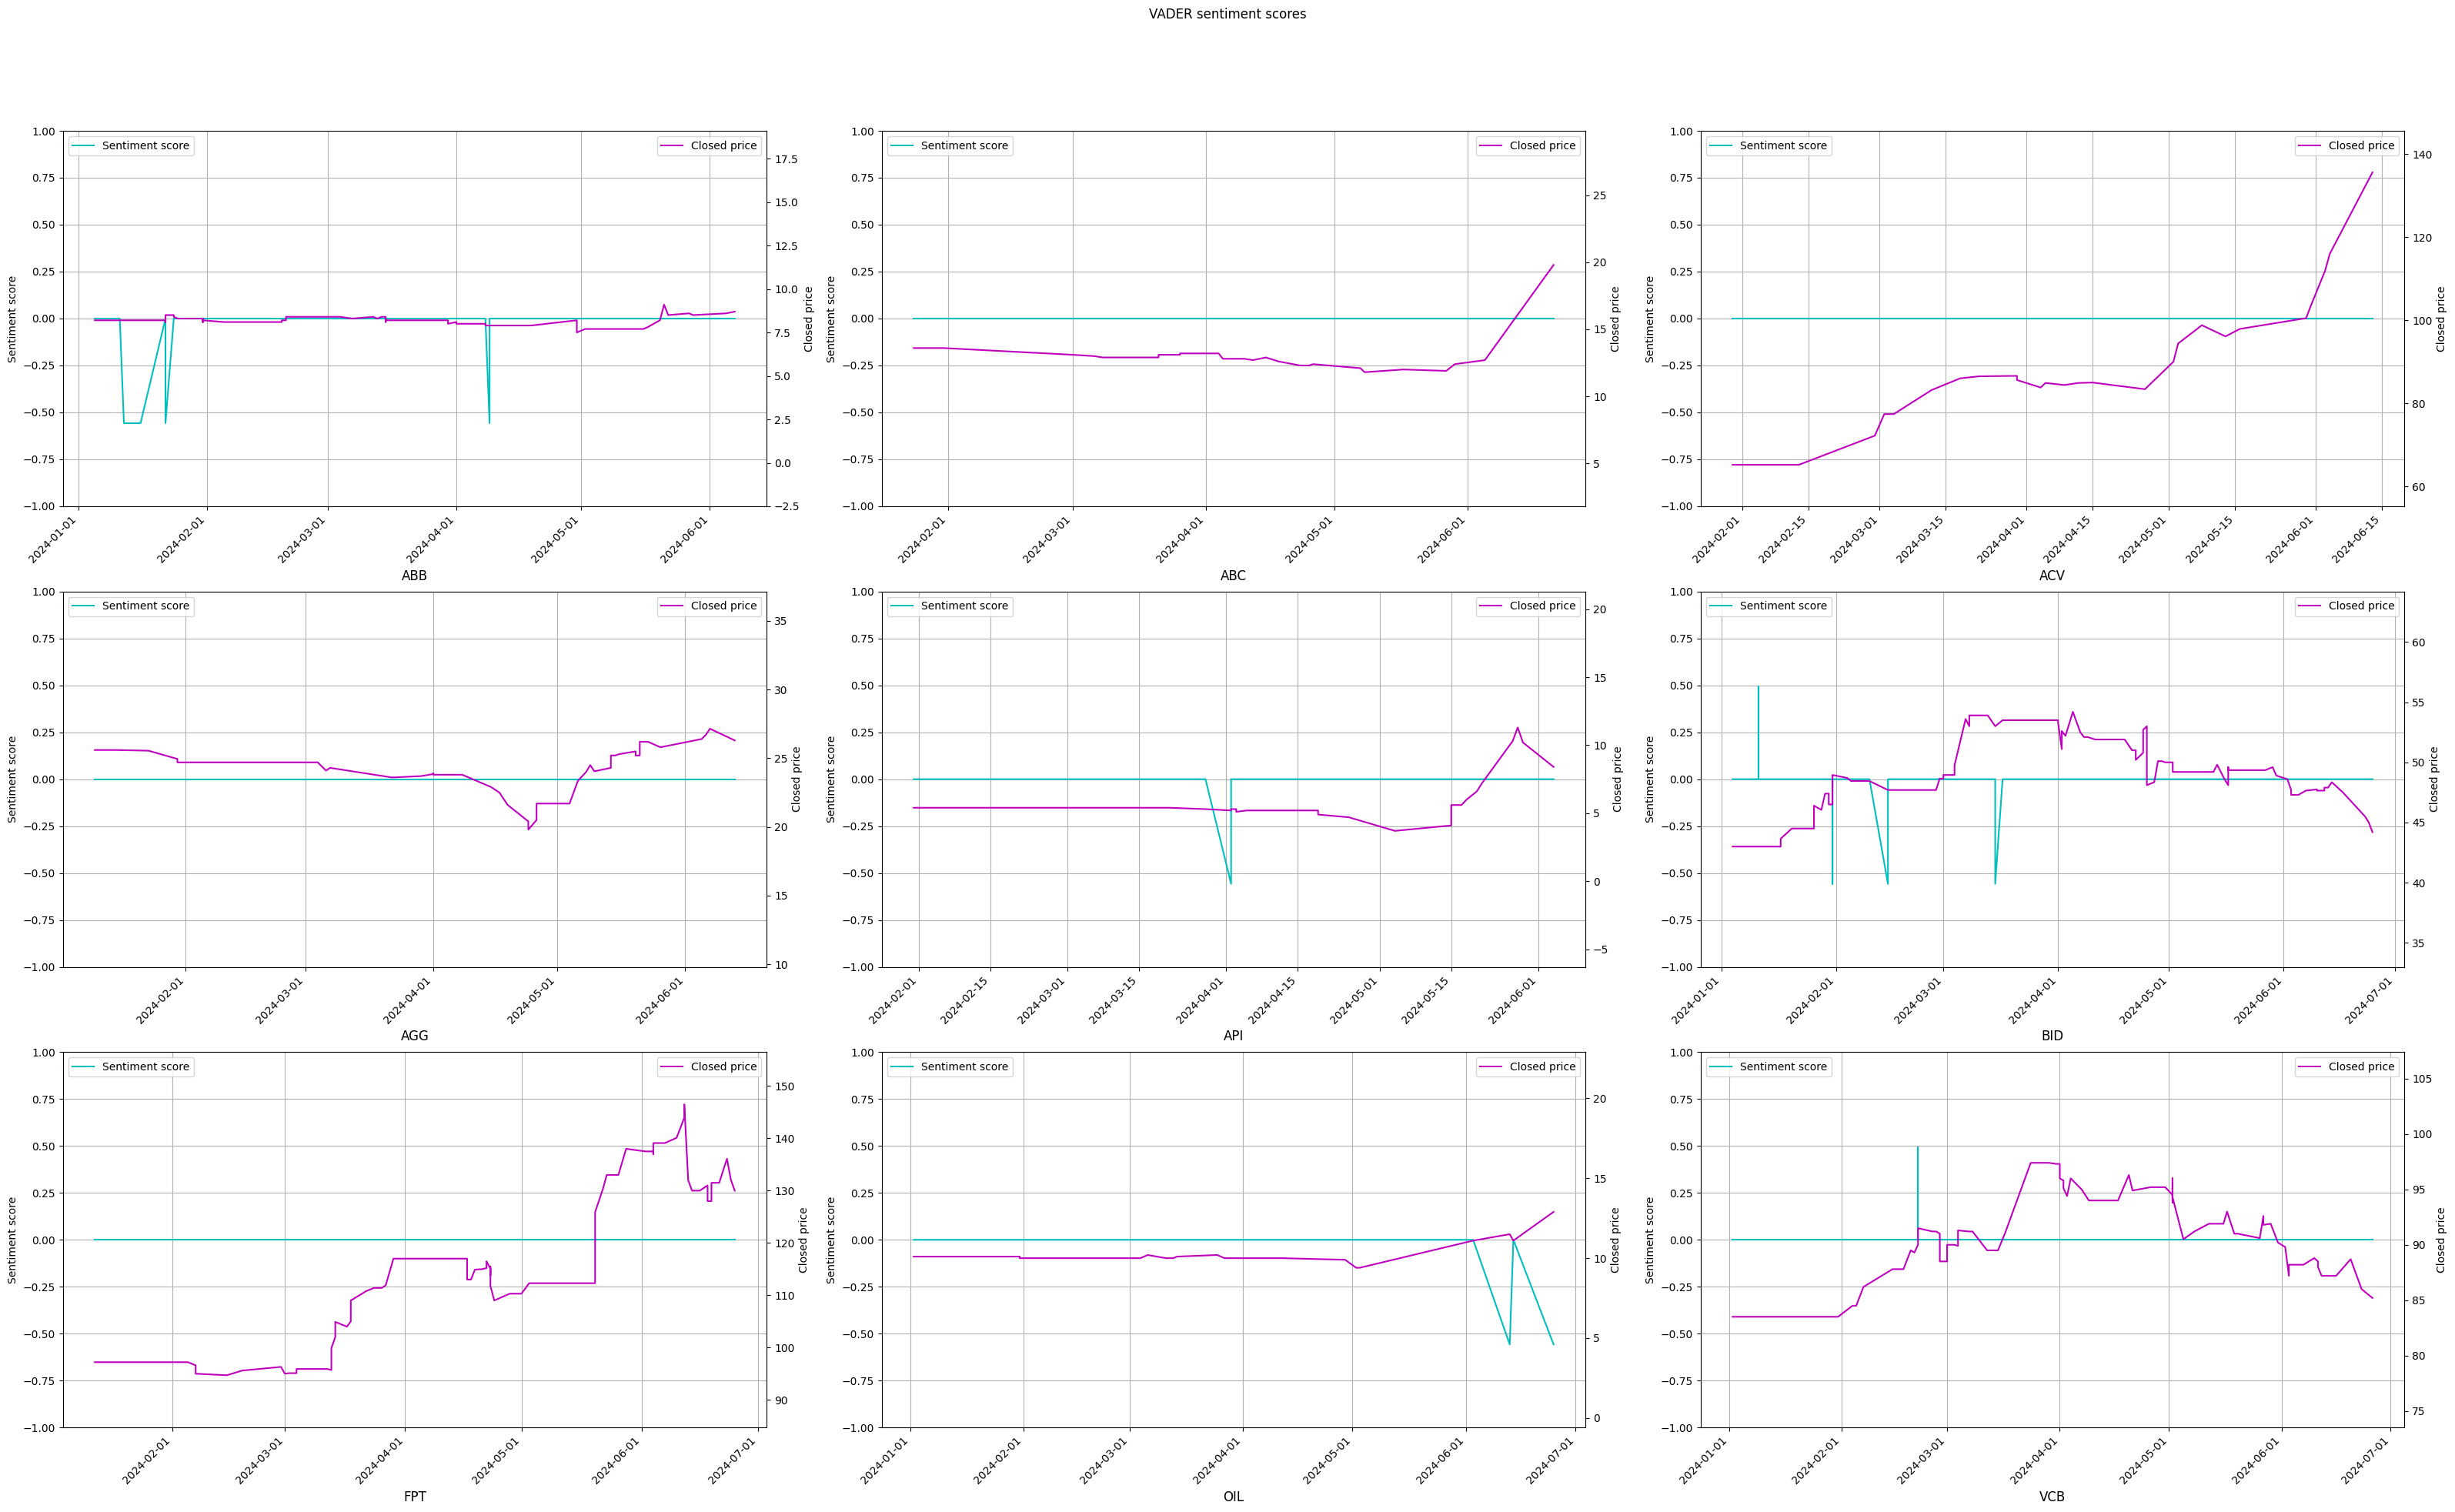

In [26]:
fig = plt.figure(figsize=(32, 20))

for company, item in company_news.items():
    date = item["timeline"]
    price = item["price"]
    sentiment_scores = item["sentiment"]
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color="c", label="Sentiment score")
    ax.legend(loc="upper left")
    ax.set_ylabel("Sentiment score")
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    axt = ax.twinx()
    axt.plot(dates, price, color="m", label="Closed price")
    axt.legend(loc="upper right")
    axt.set_ylabel("Closed price")

    axt.set_xlabel("Date")
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    vader_sentiment_scores.append(sentiment_scores)

fig.suptitle("VADER sentiment scores")
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(chart_path + "vader_sentiment_scores.png")
plt.show()

### Plot volatility


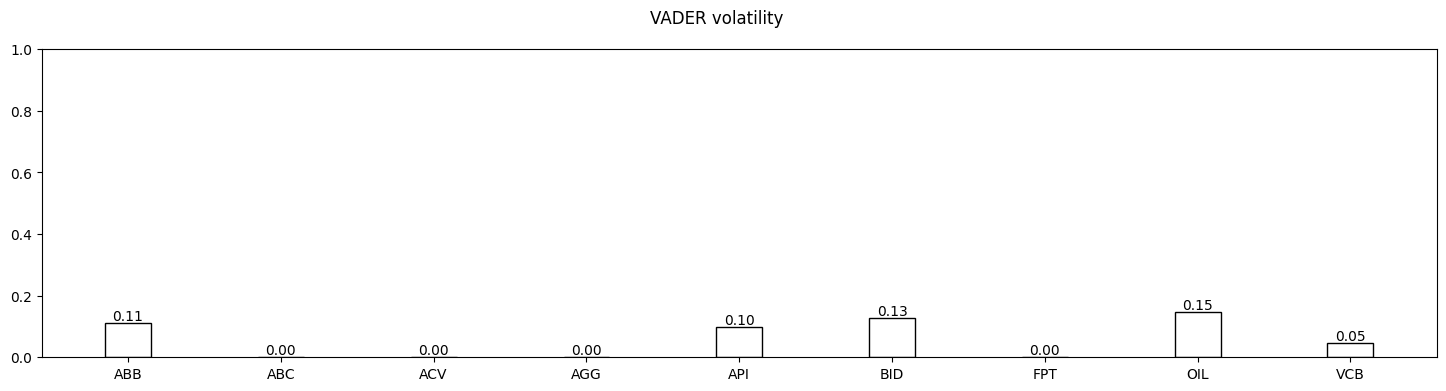

In [27]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = dict()

for company, item in company_news.items():
    sentiment_scores = item["sentiment"]
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(
        company_list.index(company),
        volatility,
        f"{volatility:.2f}",
        ha="center",
        va="bottom",
    )

ax.bar(company_list, volatility_plot.values(), 0.3, color="w", edgecolor="k")
ax.set_ylim(0, 1)

fig.suptitle("VADER volatility")
plt.savefig(chart_path + "vader_volatility.png")
plt.show()

## Use PhoBERT pretrained model from Wonrax


### Load model


In [28]:
wonrax = RobertaForSequenceClassification.from_pretrained(
    "wonrax/phobert-base-vietnamese-sentiment"
)

wonrax_tokenizer = AutoTokenizer.from_pretrained(
    "wonrax/phobert-base-vietnamese-sentiment", use_fast=False
)

In [29]:
start = timeit.default_timer()

sentiments = dict()

for company, item in company_news.items():
    company_news[company]["sentiment"] = list()
    for title in item["tokenized_news"]:
        input_ids = torch.tensor([wonrax_tokenizer.encode(title)])
        with torch.no_grad():
            out = wonrax(input_ids)
            sentiments["neg"] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments["pos"] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments["neu"] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
            sentiments["compound"] = round(sentiments["pos"] - sentiments["neg"], 4)
            company_news[company]["sentiment"].append(sentiments["compound"])
            # print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

phobert_time_execution = stop - start

### Plot sentiment score


In [30]:
phobert_sentiment_scores = list()

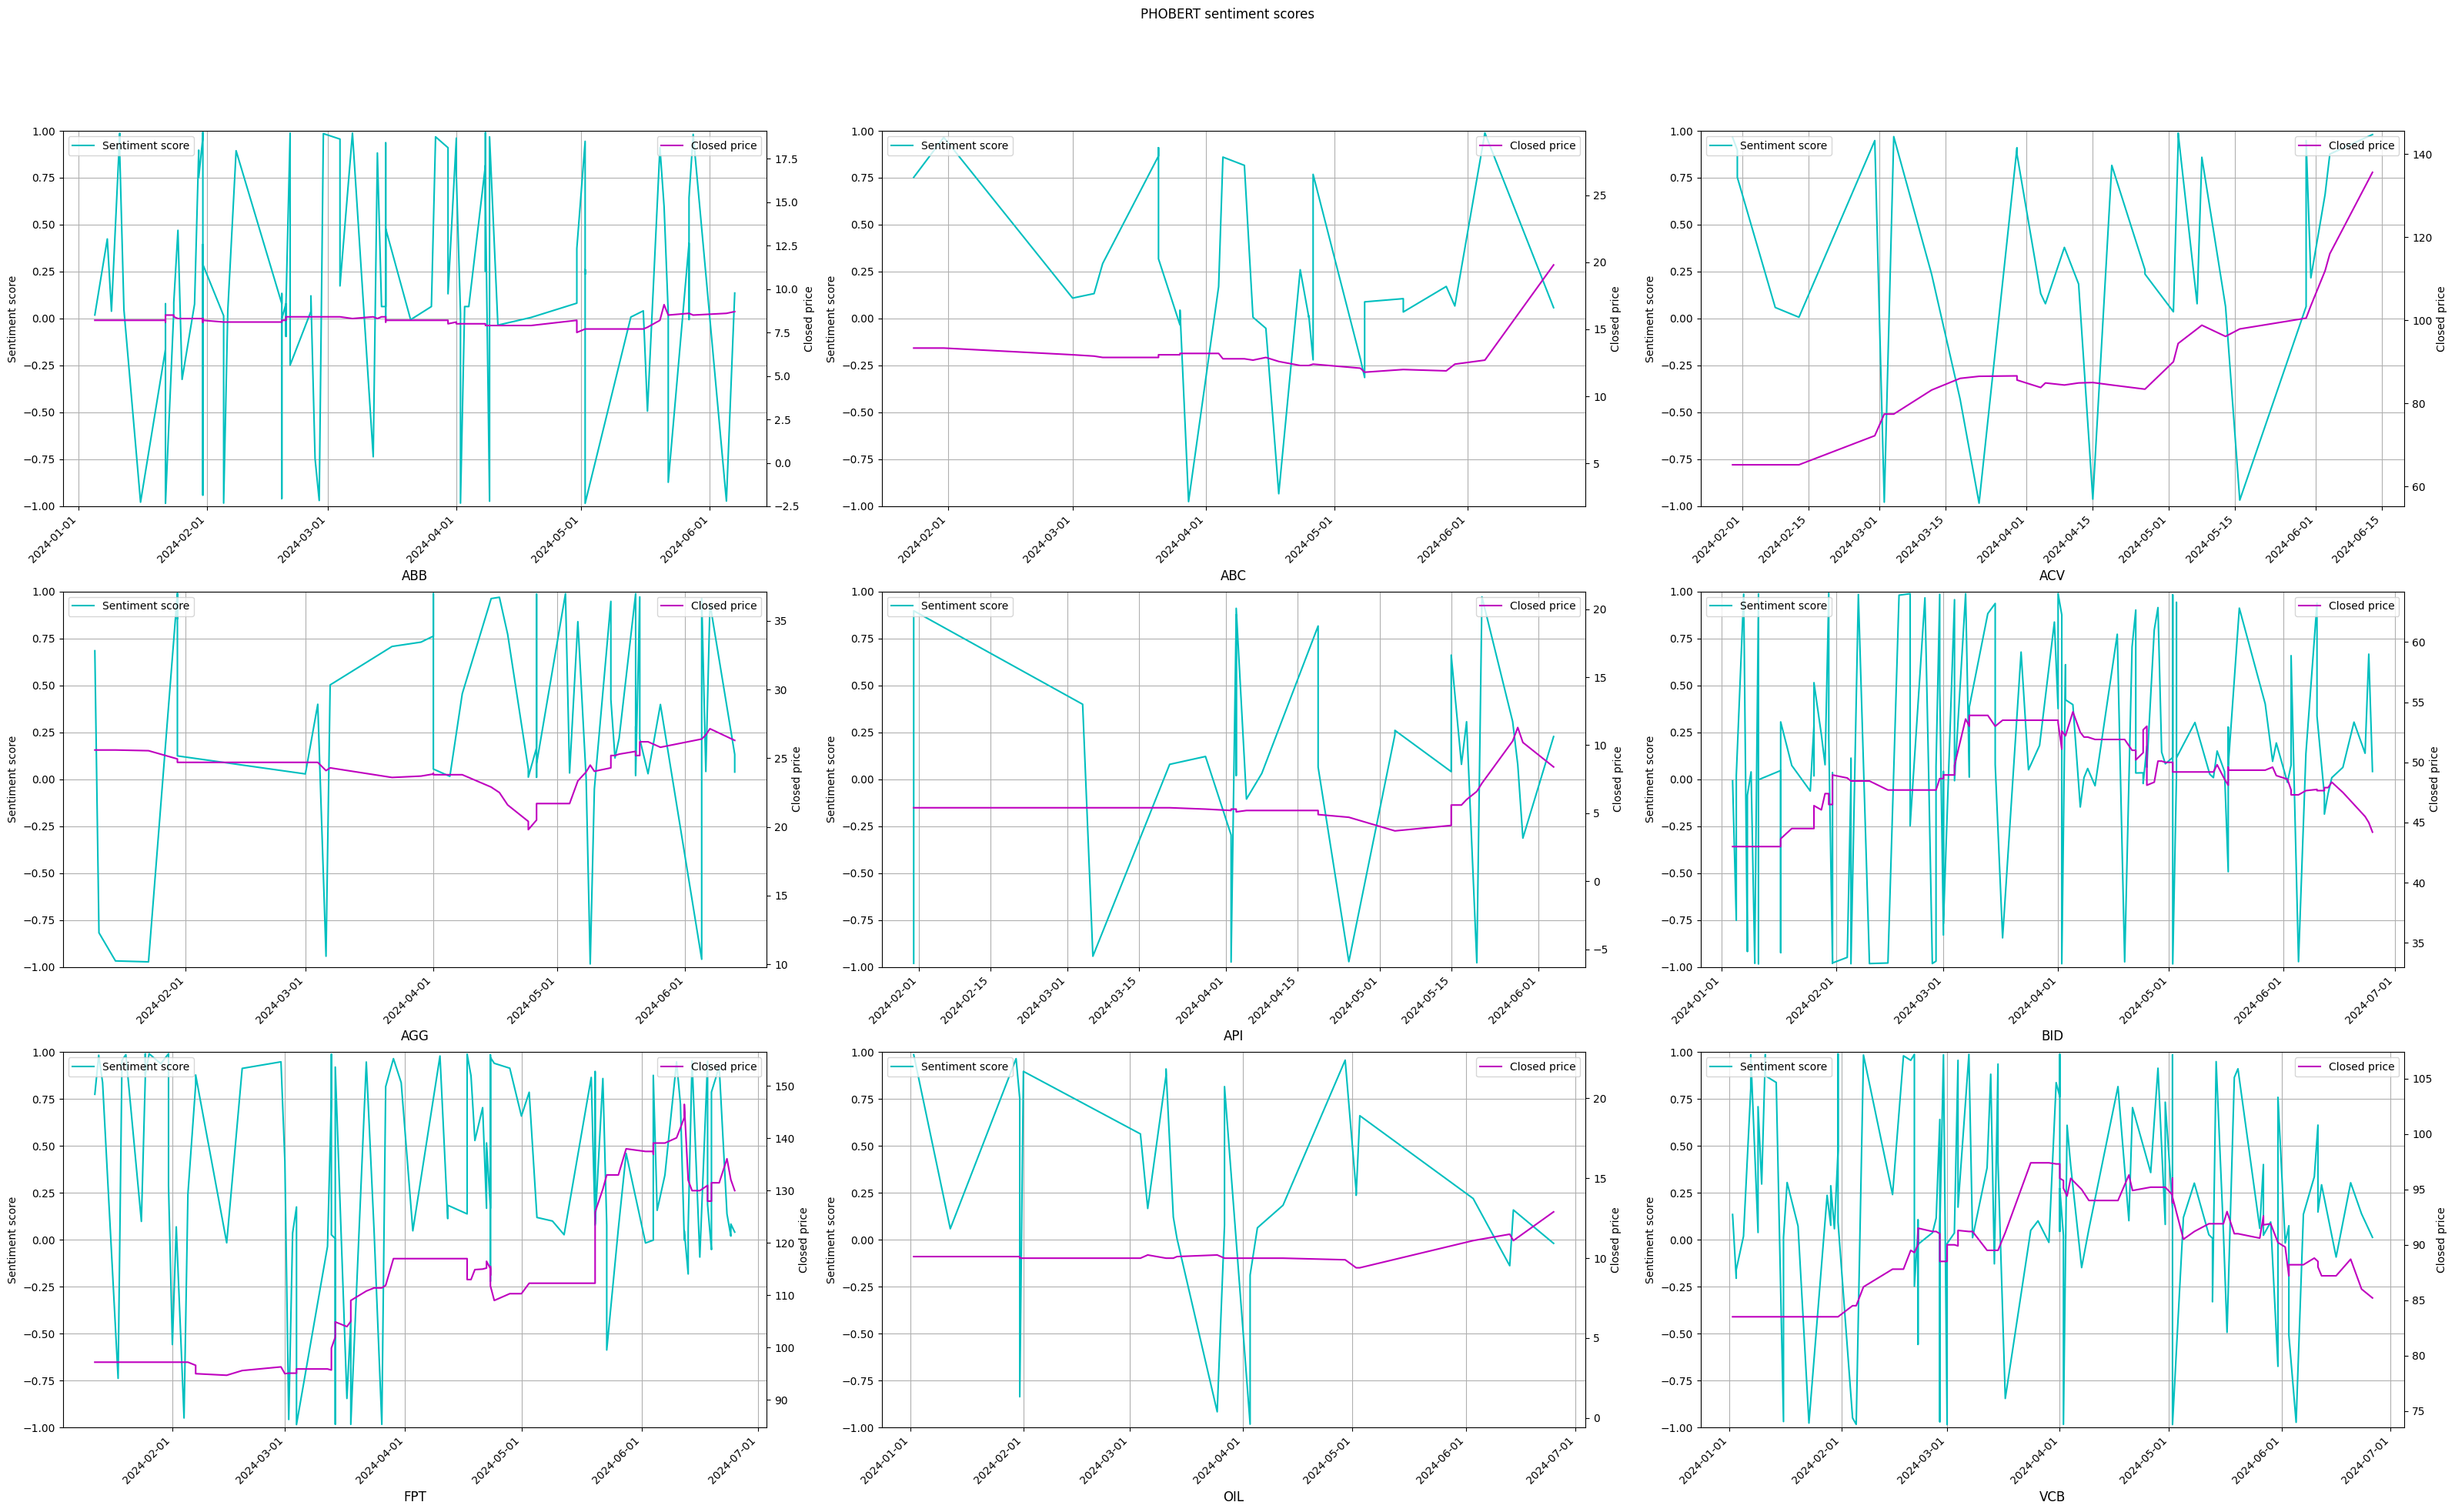

In [31]:
fig = plt.figure(figsize=(32, 20))

for company, item in company_news.items():
    date = item["timeline"]
    price = item["price"]
    sentiment_scores = item["sentiment"]
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color="c", label="Sentiment score")
    ax.legend(loc="upper left")
    ax.set_ylabel("Sentiment score")
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    axt = ax.twinx()
    axt.plot(dates, price, color="m", label="Closed price")
    axt.legend(loc="upper right")
    axt.set_ylabel("Closed price")

    axt.set_xlabel("Date")
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    phobert_sentiment_scores.append(sentiment_scores)

fig.suptitle("PHOBERT sentiment scores")
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(chart_path + "phobert_sentiment_scores.png")
plt.show()

### Plot volatility


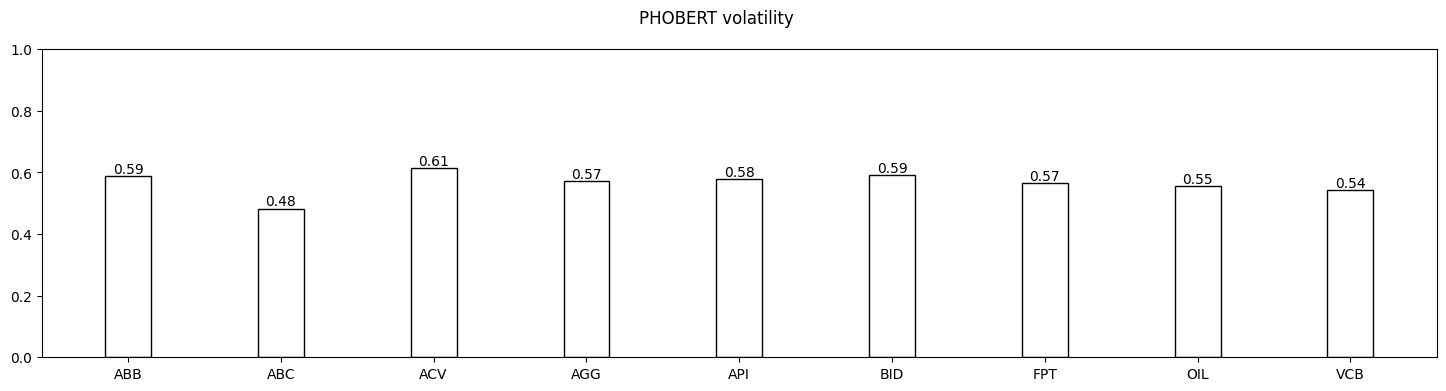

In [32]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = dict()

for company, item in company_news.items():
    sentiment_scores = item["sentiment"]
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(
        company_list.index(company),
        volatility,
        f"{volatility:.2f}",
        ha="center",
        va="bottom",
    )

ax.bar(company_list, volatility_plot.values(), 0.3, color="w", edgecolor="k")
ax.set_ylim(0, 1)

fig.suptitle("PHOBERT volatility")
plt.savefig(chart_path + "phobert_volatility.png")
plt.show()

## Use ViSoBERT


### Load model


In [34]:
uit = AutoModelForSequenceClassification.from_pretrained("uitnlp/visobert")
uit_tokenizer = AutoTokenizer.from_pretrained("uitnlp/visobert")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
start = timeit.default_timer()

sentiments = dict()

for company, item in company_news.items():
    company_news[company]["sentiment"] = list()
    for title in item["tokenized_news"]:
        encoding = uit_tokenizer(title, return_tensors="pt")
        with torch.no_grad():
            output = uit(**encoding)
            sentiments["neg"] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments["pos"] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments["compound"] = round(sentiments["pos"] - sentiments["neg"], 4)
            company_news[company]["sentiment"].append(sentiments["compound"])
            # print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

visobert_time_execution = stop - start

### Plot sentiment score


In [36]:
visobert_sentiment_scores = list()

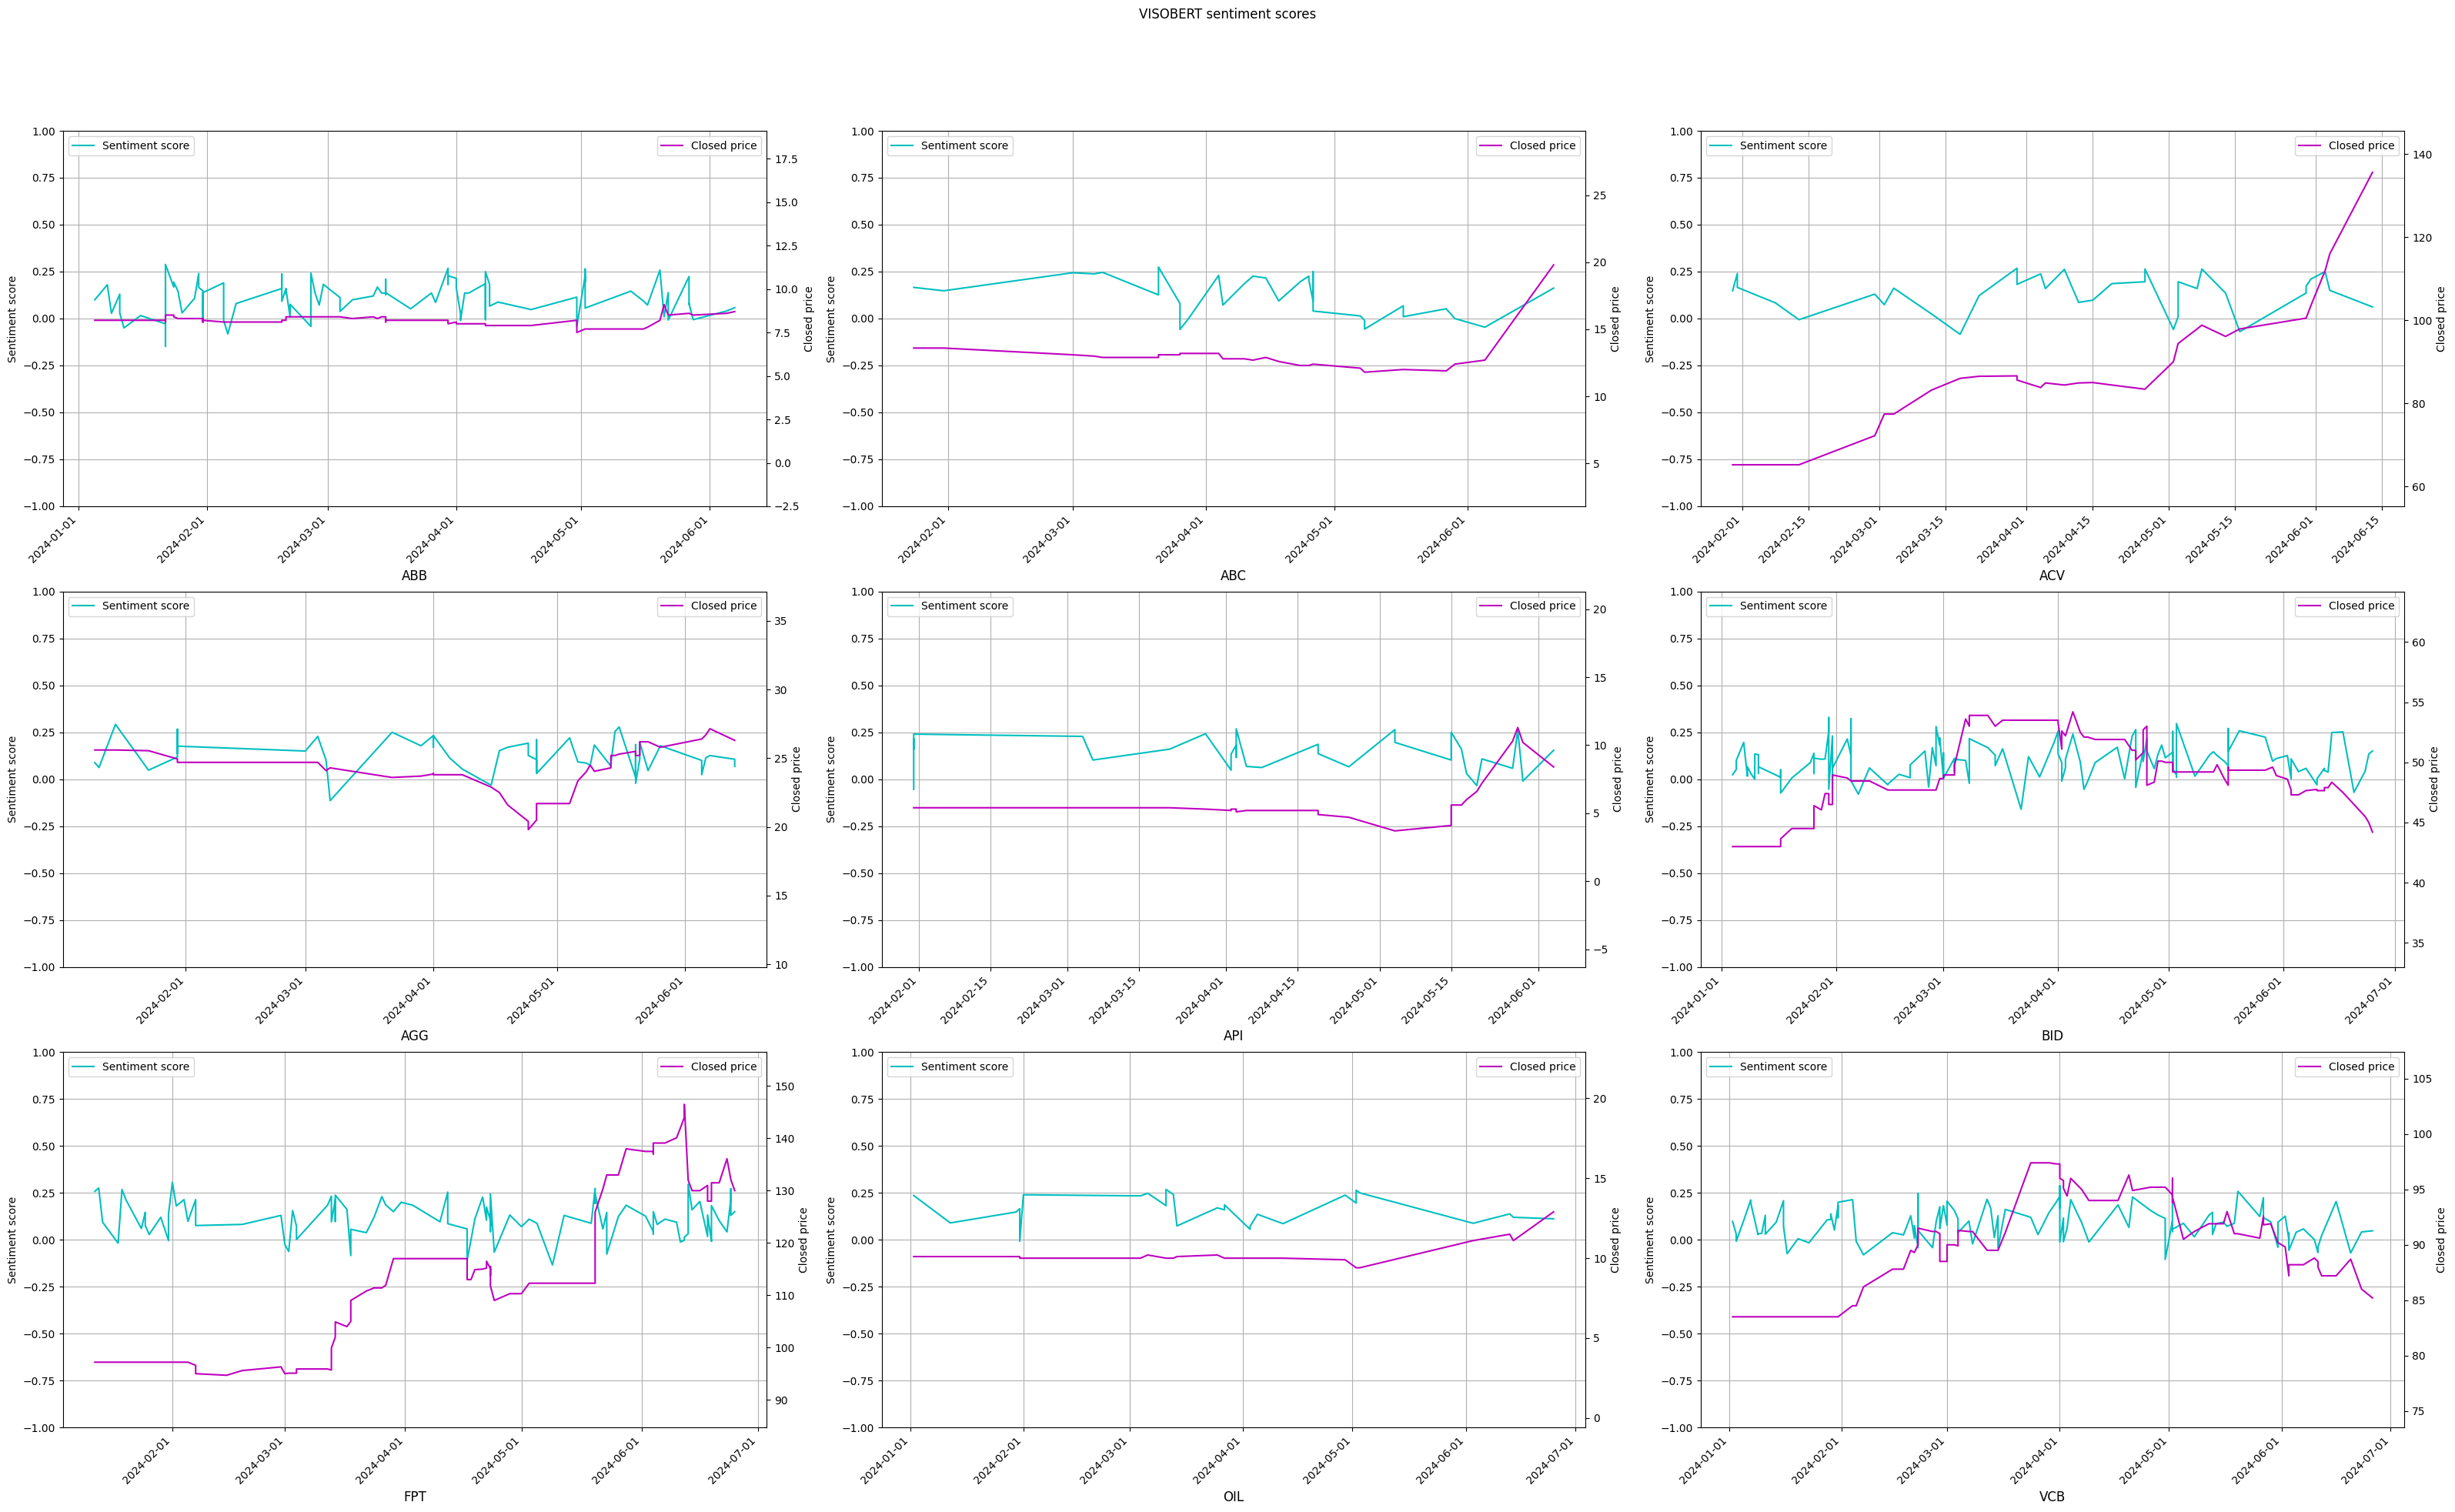

In [37]:
fig = plt.figure(figsize=(32, 20))

for company, item in company_news.items():
    date = item["timeline"]
    price = item["price"]
    sentiment_scores = item["sentiment"]
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color="c", label="Sentiment score")
    ax.legend(loc="upper left")
    ax.set_ylabel("Sentiment score")
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    axt = ax.twinx()
    axt.plot(dates, price, color="m", label="Closed price")
    axt.legend(loc="upper right")
    axt.set_ylabel("Closed price")

    axt.set_xlabel("Date")
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    visobert_sentiment_scores.append(sentiment_scores)

fig.suptitle("VISOBERT sentiment scores")
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(chart_path + "visobert_sentiment_scores.png")
plt.show()

### Plot volatility


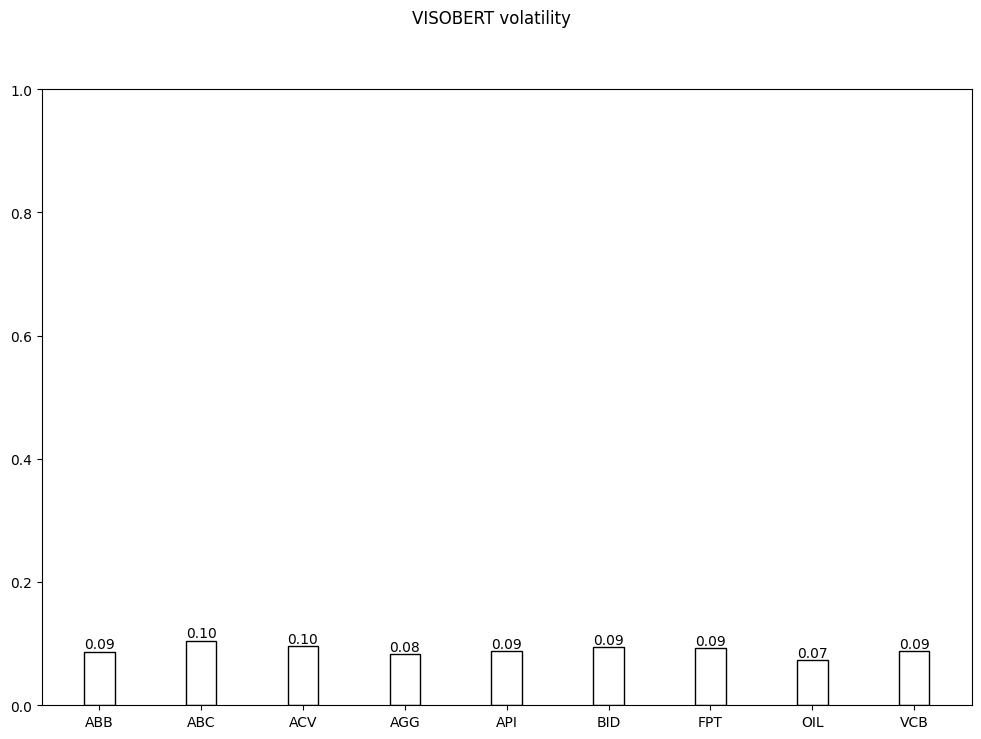

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
volatility_plot = dict()

for company, item in company_news.items():
    sentiment_scores = item["sentiment"]
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(
        company_list.index(company),
        volatility,
        f"{volatility:.2f}",
        ha="center",
        va="bottom",
    )

ax.bar(company_list, volatility_plot.values(), 0.3, color="w", edgecolor="k")
ax.set_ylim(0, 1)

fig.suptitle("VISOBERT volatility")
plt.savefig(chart_path + "visobert_volatility.png")
plt.show()

## Compare 3 models


In [39]:
sentence = "tươi"

wonrax_sentiment = dict()

input_ids = torch.tensor([wonrax_tokenizer.encode(sentence)])
with torch.no_grad():
    out = wonrax(input_ids)
    wonrax_sentiment["neg"] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
    wonrax_sentiment["pos"] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
    wonrax_sentiment["neu"] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
    wonrax_sentiment["compound"] = round(
        wonrax_sentiment["pos"] - wonrax_sentiment["neg"], 4
    )
    print("PHOBERT", wonrax_sentiment)

uit_sentiment = dict()
encoding = uit_tokenizer(sentence, return_tensors="pt")
with torch.no_grad():
    output = uit(**encoding)
    uit_sentiment["neg"] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
    uit_sentiment["pos"] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
    uit_sentiment["compound"] = round(uit_sentiment["pos"] - uit_sentiment["neg"], 4)
    print("VISOBERT", uit_sentiment)

# print("VADER", analyzer.polarity_scores(sentence))

PHOBERT {'neg': 0.001, 'pos': 0.992, 'neu': 0.007, 'compound': 0.991}
VISOBERT {'neg': 0.375, 'pos': 0.625, 'compound': 0.25}


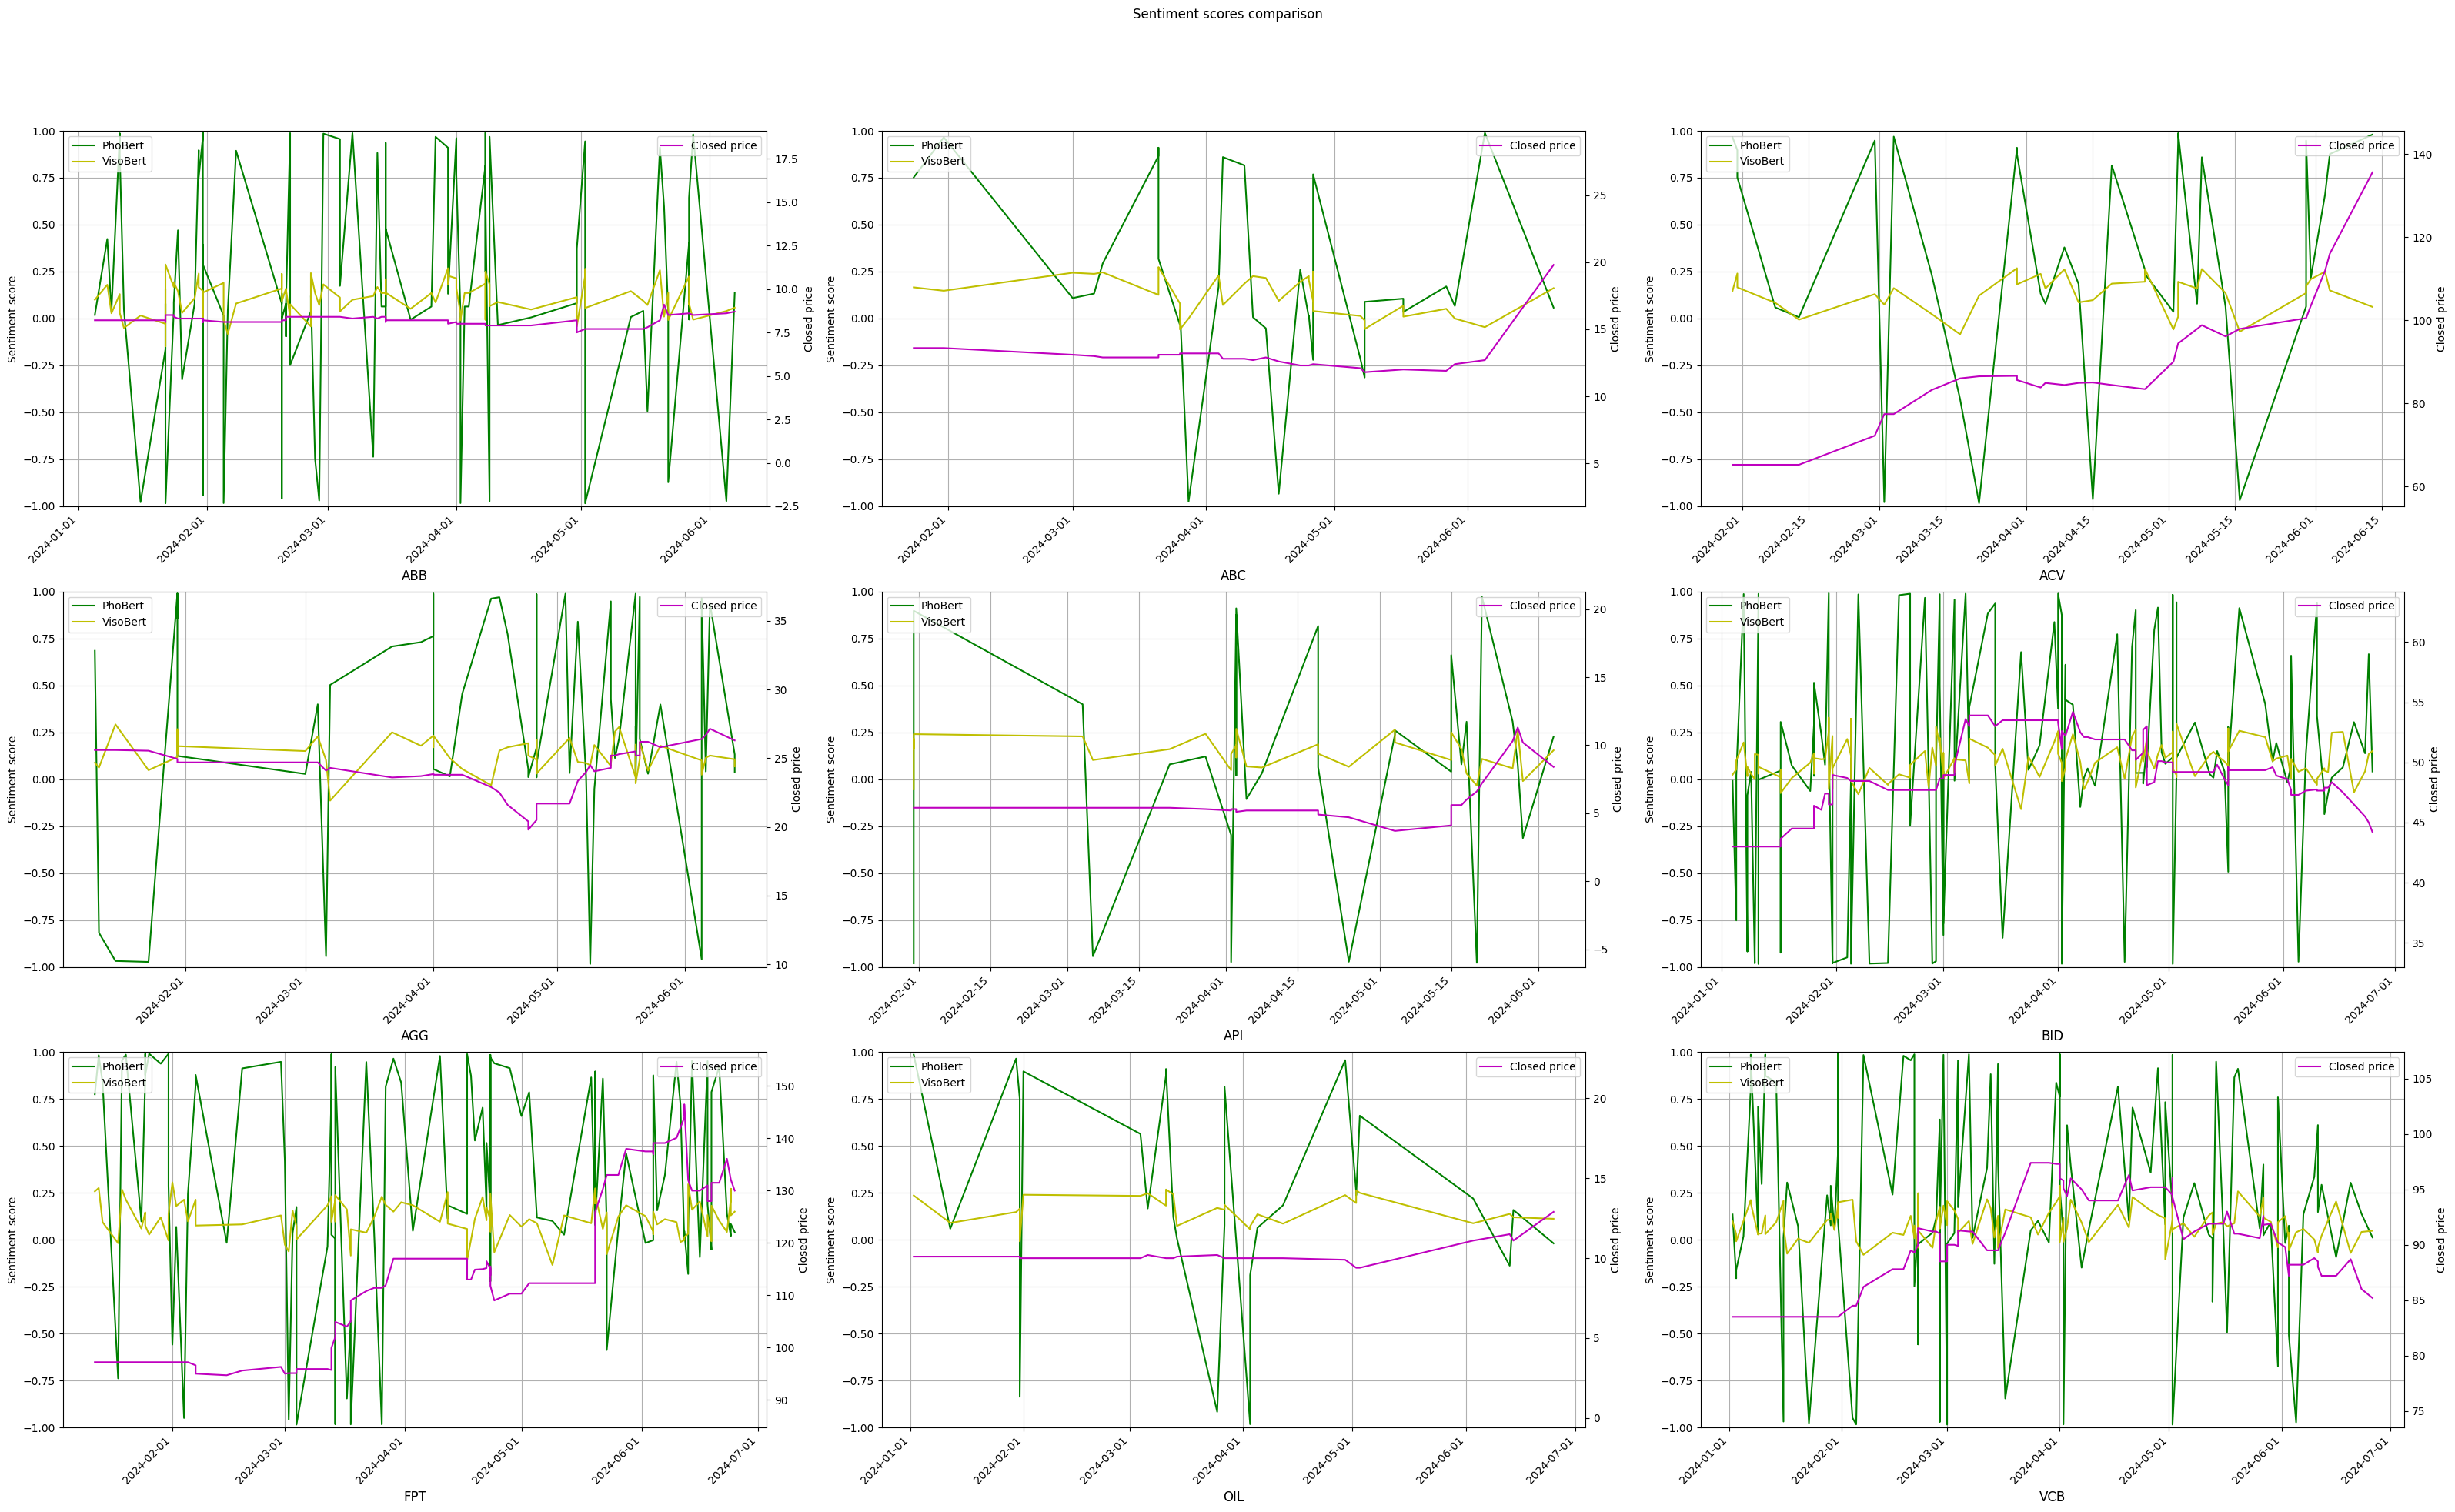

In [40]:
fig = plt.figure(figsize=(32, 20))

max_length = len(company_news[company_list[0]]["timeline"])

for idx, company in enumerate(company_list):
    date = date_time[idx]
    plot_index = idx + 1
    plot_col = 3
    plot_row = len(company_list) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)

    # ax.plot(dates, vader_sentiment_scores[idx], color='c', label='VADER')
    ax.plot(dates, phobert_sentiment_scores[idx], color="g", label="PhoBert")
    ax.plot(dates, visobert_sentiment_scores[idx], color="y", label="VisoBert")
    ax.legend(loc="upper left")
    ax.set_ylabel("Sentiment score")
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    axt = ax.twinx()
    axt.plot(dates, stock_price[idx], color="m", label="Closed price")
    axt.legend(loc="upper right")
    axt.set_ylabel("Closed price")

    axt.set_ylim(min(stock_price[idx]) - 10, max(stock_price[idx]) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.suptitle("Sentiment scores comparison")
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(chart_path + "compare_sentiment_scores.png")
plt.show()

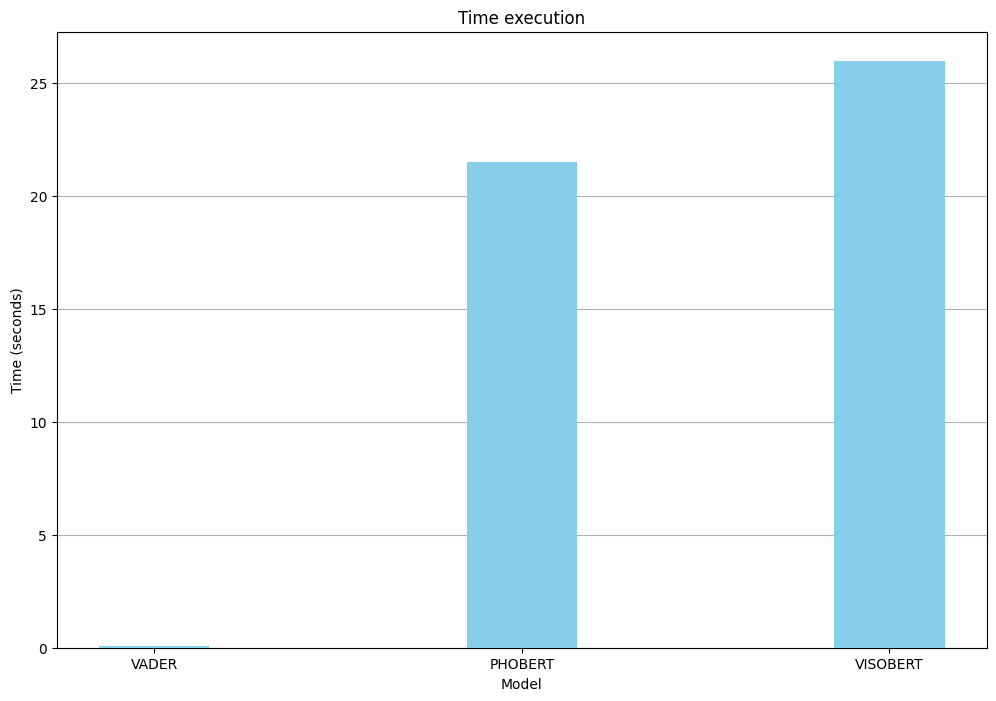

In [41]:
time_execution = {
    "VADER": vader_time_execution,
    "PHOBERT": phobert_time_execution,
    "VISOBERT": visobert_time_execution,
}

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.grid(zorder=0)
ax.bar(
    time_execution.keys(), time_execution.values(), color="skyblue", width=0.3, zorder=3
)
ax.set_title("Time execution")
ax.set_xlabel("Model")
ax.set_ylabel("Time (seconds)")
plt.savefig(chart_path + "compare_time_execution.png")
plt.show()